In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import *
from torchvision.datasets import ImageFolder

In [26]:
learning_rate=0.001
num_epochs = 40
momentum=0.9
weight_decay=1e-5
batch_size_train=256
batch_size_test=256
batch_size = 256

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 加載數據集
train_dataset = ImageFolder(root='/root/notebooks/nfs/work/barry.chen/DenoisingDiffusionProbabilityModel-ddpm-/dataset/only_group1_add', transform=transform)
test_dataset = ImageFolder(root='/root/notebooks/nfs/work/barry.chen/DenoisingDiffusionProbabilityModel-ddpm-/dataset/broke_F1210', transform=transform_test)
# test_dataset = ImageFolder(root='/root/notebooks/nfs/work/barry.chen/Phison/Conditional_Diffusion/CDDIM/select', transform=transform)
# # 創建 DataLoader
# # 分割數據集
# train_size = int(0.8 * len(dataset))  # 假設80%用於訓練
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 創建 DataLoader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 檢查數據集的類別
classes = train_dataset.classes
print("Classes:", classes)


# 顯示數據集的大小
print("train Dataset size:", len(train_dataset))
print("test Dataset size:", len(test_dataset))

Classes: ['broke', 'good', 'shift']
train Dataset size: 15150
test Dataset size: 29


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)
print(torch.cuda.get_device_name())

Device:  cuda:0
Tesla V100-PCIE-32GB


In [10]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 2
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = self.dropout(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [42]:
model = resnet152()
model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 3),
    )
model = model.cuda()

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [27]:
use_gpu = True
train_acc = []
start = time.time()
loss_list = []
running_loss = 0
total_step = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):       
        # gpu
        if use_gpu:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
            
        outputs = model(images)
        
        loss = criterion(outputs, labels)

            
        
        # backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 25 == 24: # print every 500 mini batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i+1,running_loss/25))
            running_loss = 0.0
        
        if i % 7 == 0:
            print("epoch: {} {}/{}".format(epoch,i,total_step))


    # train
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data

            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)


            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy train %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    # test

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data      
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)                
            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy test %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)
    loss_list.append(loss.item())


end= time.time()
stopWatch = end-start
print( "Training is done")
print('Total Training Time (second):',stopWatch)

epoch: 0 0/60
epoch: 0 7/60
epoch: 0 14/60
epoch: 0 21/60
[1,    25] loss: 0.345
epoch: 0 28/60
epoch: 0 35/60
epoch: 0 42/60
[1,    50] loss: 0.351
epoch: 0 49/60
epoch: 0 56/60
Accuracy train 83 %
Accuracy test 44 %
epoch: 1 0/60
epoch: 1 7/60
epoch: 1 14/60
epoch: 1 21/60
[2,    25] loss: 0.458
epoch: 1 28/60
epoch: 1 35/60
epoch: 1 42/60
[2,    50] loss: 0.313
epoch: 1 49/60
epoch: 1 56/60
Accuracy train 84 %
Accuracy test 51 %
epoch: 2 0/60
epoch: 2 7/60
epoch: 2 14/60
epoch: 2 21/60
[3,    25] loss: 0.474
epoch: 2 28/60
epoch: 2 35/60
epoch: 2 42/60
[3,    50] loss: 0.325
epoch: 2 49/60
epoch: 2 56/60
Accuracy train 85 %
Accuracy test 65 %
epoch: 3 0/60
epoch: 3 7/60
epoch: 3 14/60
epoch: 3 21/60
[4,    25] loss: 0.435
epoch: 3 28/60
epoch: 3 35/60
epoch: 3 42/60
[4,    50] loss: 0.299
epoch: 3 49/60
epoch: 3 56/60
Accuracy train 85 %
Accuracy test 58 %
epoch: 4 0/60
epoch: 4 7/60
epoch: 4 14/60
epoch: 4 21/60
[5,    25] loss: 0.436
epoch: 4 28/60
epoch: 4 35/60
epoch: 4 42/60
[5

In [33]:
classes = ['good','broke','shift']

In [34]:
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, testloader)
print('F1 score: %f' % f1_score(actuals, predictions, average='weighted'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

F1 score: 1.000000
Accuracy score: 1.000000


[[29]]


/tmp/ipykernel_251779/3249040878.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
/tmp/ipykernel_251779/3249040878.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


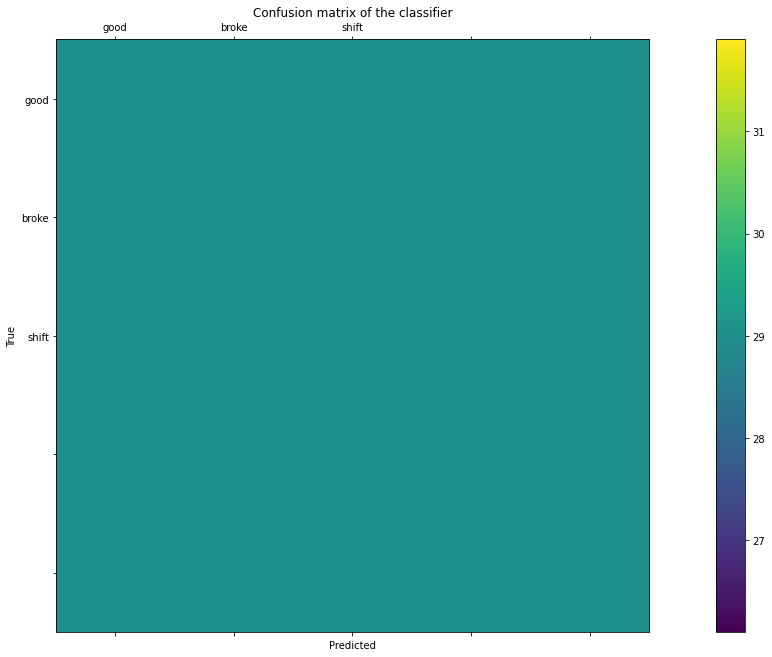

In [30]:
cm = confusion_matrix(actuals, predictions)
print(cm)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [31]:
 print(classification_report(actuals, predictions, target_names=classes, digits=5))

ValueError: Number of classes, 1, does not match size of target_names, 3. Try specifying the labels parameter

In [64]:
batch_size=256

train_dataset = ImageFolder(root='/root/notebooks/nfs/work/barry.chen/DenoisingDiffusionProbabilityModel-ddpm-/dataset/only_group1', transform=transform)
test_dataset = ImageFolder(root='/root/notebooks/nfs/work/barry.chen/DenoisingDiffusionProbabilityModel-ddpm-/dataset/broke_F1210', transform=transform_test)
# test_dataset = ImageFolder(root='/root/notebooks/nfs/work/barry.chen/Phison/Conditional_Diffusion/CDDIM/select', transform=transform)
# # 創建 DataLoader
# # 分割數據集
# train_size = int(0.8 * len(dataset))  # 假設80%用於訓練
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 創建 DataLoader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 檢查數據集的類別
classes = train_dataset.classes
print("Classes:", classes)


# 顯示數據集的大小
print("train Dataset size:", len(train_dataset))
print("test Dataset size:", len(test_dataset))

Classes: ['broke', 'good', 'shift']
train Dataset size: 9595
test Dataset size: 29


In [65]:
model = resnet152()
model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 3),
    )
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [66]:
use_gpu = True
train_acc = []
start = time.time()
loss_list = []
running_loss = 0
total_step = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):       
        # gpu
        if use_gpu:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)
            
        outputs = model(images)
         
        loss = criterion(outputs, labels)

            
        
        # backward and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 25 == 24: # print every 500 mini batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i+1,running_loss/25))
            running_loss = 0.0
        
        if i % 7 == 0:
            print("epoch: {} {}/{}".format(epoch,i,total_step))


    # train
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data

            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)


            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy train %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)

    # test

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data      
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)                
            outputs = model(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy test %d %%"%(100*correct/total))
    train_acc.append(100*correct/total)
    loss_list.append(loss.item())


end= time.time()
stopWatch = end-start
print( "Training is done")
print('Total Training Time (second):',stopWatch)

epoch: 0 0/38
epoch: 0 7/38
epoch: 0 14/38
epoch: 0 21/38
[1,    25] loss: 0.838
epoch: 0 28/38
epoch: 0 35/38
Accuracy train 54 %
Accuracy test 0 %
epoch: 1 0/38
epoch: 1 7/38
epoch: 1 14/38
epoch: 1 21/38
[2,    25] loss: 1.176
epoch: 1 28/38
epoch: 1 35/38
Accuracy train 62 %
Accuracy test 0 %
epoch: 2 0/38
epoch: 2 7/38
epoch: 2 14/38
epoch: 2 21/38
[3,    25] loss: 1.052
epoch: 2 28/38
epoch: 2 35/38
Accuracy train 63 %
Accuracy test 0 %
epoch: 3 0/38
epoch: 3 7/38
epoch: 3 14/38
epoch: 3 21/38
[4,    25] loss: 1.014
epoch: 3 28/38
epoch: 3 35/38
Accuracy train 68 %
Accuracy test 0 %
epoch: 4 0/38
epoch: 4 7/38
epoch: 4 14/38
epoch: 4 21/38
[5,    25] loss: 0.956
epoch: 4 28/38
epoch: 4 35/38
Accuracy train 69 %
Accuracy test 0 %
epoch: 5 0/38
epoch: 5 7/38
epoch: 5 14/38
epoch: 5 21/38
[6,    25] loss: 0.920
epoch: 5 28/38
epoch: 5 35/38
Accuracy train 70 %
Accuracy test 0 %
epoch: 6 0/38
epoch: 6 7/38
epoch: 6 14/38
epoch: 6 21/38
[7,    25] loss: 0.884
epoch: 6 28/38
epoch: 6 3

KeyboardInterrupt: 